In [436]:
import  pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics  import confusion_matrix,roc_auc_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection  import GridSearchCV
from sklearn.svm import SVC

In [437]:
df=pd.read_json('../input/loan-application-data/loan_data.json')

In [438]:
df.head()

,Application_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Income,Application_Status
0,LP001002,Male,No,0,Graduate,No,1,Urban,medium,Y
1,LP001003,Male,Yes,1,Graduate,No,1,Rural,medium,N
2,LP001005,Male,Yes,0,Graduate,Yes,1,Urban,low,Y
3,LP001006,Male,Yes,0,Not Graduate,No,1,Urban,low,Y
4,LP001008,Male,No,0,Graduate,No,1,Urban,medium,Y


In [439]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Application_ID      511 non-null    object
 1   Gender              511 non-null    object
 2   Married             511 non-null    object
 3   Dependents          511 non-null    object
 4   Education           511 non-null    object
 5   Self_Employed       511 non-null    object
 6   Credit_History      511 non-null    int64 
 7   Property_Area       511 non-null    object
 8   Income              511 non-null    object
 9   Application_Status  511 non-null    object
dtypes: int64(1), object(9)
memory usage: 40.0+ KB


In [440]:
df.describe()

,Credit_History
count,511.000000
mean,0.843444
std,0.363738
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [441]:
df['Dependents'].value_counts()

0     294
2      88
1      85
3+     44
Name: Dependents, dtype: int64

# 1. Find % of total applicants for each unique value of dependents. 

In [442]:
# grouping on the basis of 'dependents' columns
g=df.groupby('Dependents')

In [443]:
Total_applications=511  #or df.shape[0]
for group,df1 in g:
    print('Percentage of total applicants having',group,'no. of dependents is:')
    print(((df1.shape[0])/(df.shape[0]))*100,'%\n\n')
    

Percentage of total applicants having 0 no. of dependents is:
57.534246575342465 %


Percentage of total applicants having 1 no. of dependents is:
16.634050880626223 %


Percentage of total applicants having 2 no. of dependents is:
17.22113502935421 %


Percentage of total applicants having 3+ no. of dependents is:
8.610567514677104 %




# 2. Find the average number of dependents per applicant.


In [444]:
# #average number of dependents per applicant = total no. of dependents / total no. of applicants
Total_dependents=0
for i in df['Dependents']:
    if i=='3+' :
        Total_dependents+=3
    else:
        Total_dependents+=int(i)
        
Total_applicants= df.shape[0]
average_number_of_dependents_per_applicant=Total_dependents/Total_applicants
print('average number of dependents per applicant is: ',round(average_number_of_dependents_per_applicant,2))

average number of dependents per applicant is:  0.77


# 3. Find the %of applications approved for self-employed applicants.


In [445]:
No_of_selfemployed_applicants=df[df['Self_Employed']=='Yes'].shape[0]
print('%of applications approved for self-employed applicants is : ',(No_of_selfemployed_applicants/Total_applicants)*100,'%')

%of applications approved for self-employed applicants is :  13.698630136986301 %


# 4. What is the % of rejections for married male applicants?


In [446]:
No_of_married_males_rejected=df[(df['Married']=='Yes') & (df['Application_Status']=='N') & (df['Gender']=='Male')].shape[0]

total_no_of_married_males_applied=df[(df['Married']=='Yes') &  (df['Gender']=='Male')].shape[0]

percentage_of_rejections_for_married_male_applicants= (No_of_married_males_rejected/total_no_of_married_males_applied)*100

print('% of rejections for married male applicants is:' , percentage_of_rejections_for_married_male_applicants,'%')

% of rejections for married male applicants is: 28.431372549019606 %


# 5. Which property area has the maximum approval ratio.


In [447]:
#grouping by property_area
p=df.groupby('Property_Area')
for group,df1 in p:
    approvals=df1[df1['Application_Status']=='Y'].shape[0]
    total_application_from_that_property_area=df1.shape[0]
    approval_ratio=approvals/total_application_from_that_property_area
    print(f'the approval ratio for {group} property is {approval_ratio}')

the approval ratio for Rural property is 0.6040268456375839
the approval ratio for Semiurban property is 0.7766497461928934
the approval ratio for Urban property is 0.6303030303030303


### Thus the approval ratio is maximum from Rural area (i.e. 0.7)

# 6. Find average dependents per income group.


In [448]:
#avg_dependentin_x_income_grp=(Total dependents)/(Total no. of income groups)
#grouping by income_group
Total_no_of_income_grps=len(df['Income'].value_counts())
Avg_dependent_per_income_group=Total_dependents/Total_no_of_income_grps
print('average dependents per income group is :',Avg_dependent_per_income_group)

average dependents per income group is : 131.0


# 7. Create a simple predictive model to assess whether a loan application will be approved or rejected and provide the accuracy score.


In [449]:
df.head()

,Application_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Income,Application_Status
0,LP001002,Male,No,0,Graduate,No,1,Urban,medium,Y
1,LP001003,Male,Yes,1,Graduate,No,1,Rural,medium,N
2,LP001005,Male,Yes,0,Graduate,Yes,1,Urban,low,Y
3,LP001006,Male,Yes,0,Not Graduate,No,1,Urban,low,Y
4,LP001008,Male,No,0,Graduate,No,1,Urban,medium,Y


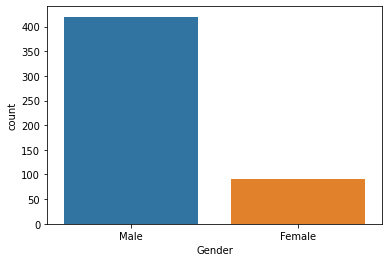

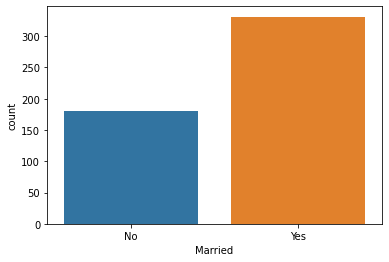

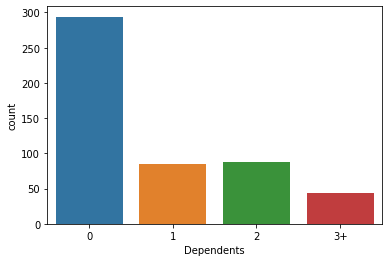

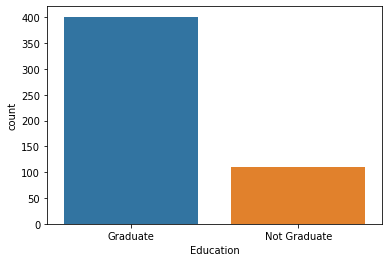

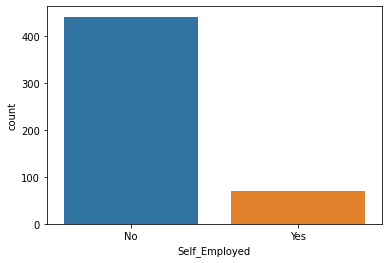

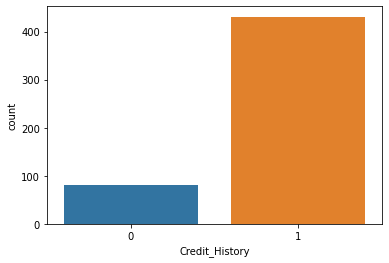

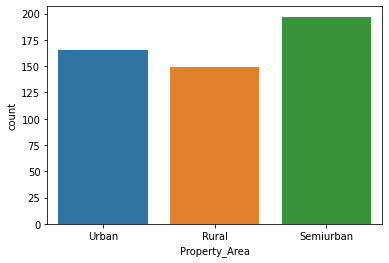

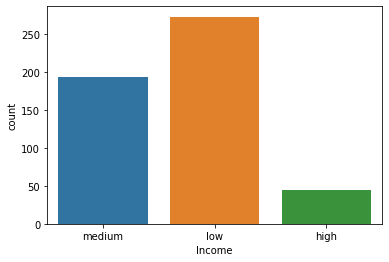

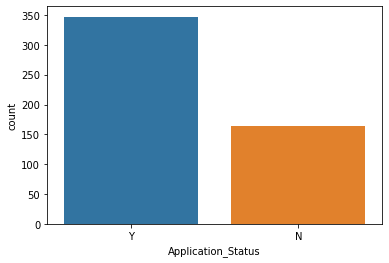

In [450]:
import warnings
warnings.filterwarnings('ignore')
for column in df.drop('Application_ID',axis=1).columns:
    sns.countplot(df[column])
    plt.show()

#### Pretty much unbalanced data

In [451]:
#making a copy so that original dataset remains same
df_new=df.copy()

In [452]:
#dropping Application_Id column
df_new.drop('Application_ID',axis=1,inplace=True)

In [453]:
#label encoding of categorical columns
categ_columns=[column for column in df_new.columns if df_new[column].dtype=='object']

In [454]:
categ_columns

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Income',
 'Application_Status']

In [455]:
for column in categ_columns:
    le=LabelEncoder()
    df_new[column]=le.fit_transform(df_new[column])

In [456]:
df_new.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Income,Application_Status
0,1,0,0,0,0,1,2,2,1
1,1,1,1,0,0,1,0,2,0
2,1,1,0,0,1,1,2,1,1
3,1,1,0,1,0,1,2,1,1
4,1,0,0,0,0,1,2,2,1


In [457]:
# df_new.drop(['Property_Area','Gender','Married'],axis=1,inplace=True)

In [458]:
X_train, X_test, y_train, y_test =train_test_split(df_new.drop('Application_Status',axis=1),df_new['Application_Status'],test_size=0.2)

#  Logistic regression

In [459]:
lr_model=LogisticRegression()
lr_model.fit(X_train,y_train)

LogisticRegression()

In [460]:
lr_model.score(X_test,y_test)

0.8737864077669902

In [461]:
y_pred_lr=lr_model.predict(X_test)
roc_auc_score(y_test,y_pred_lr)

0.803030303030303

In [462]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.61      0.75        33
           1       0.84      1.00      0.92        70

    accuracy                           0.87       103
   macro avg       0.92      0.80      0.83       103
weighted avg       0.89      0.87      0.86       103



In [463]:
confusion_matrix(y_test,y_pred_lr)

array([[20, 13],
       [ 0, 70]])

<AxesSubplot:>

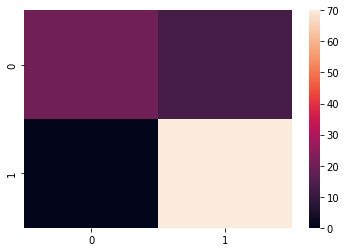

In [464]:
sns.heatmap(confusion_matrix(y_test,y_pred_lr))

# Decision tree classifier

In [465]:
params_cv_dt=[{'max_depth':(list(range(1,50)))}]
dt_model=DecisionTreeClassifier()
cv_dt=GridSearchCV(estimator=dt_model,param_grid=params_cv_dt)


In [466]:
cv_dt.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                        13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                        23, 24, 25, 26, 27, 28, 29, 30, ...]}])

In [467]:
y_pred_cv_dt=cv_dt.predict(X_test)
confusion_matrix(y_test,y_pred_cv_dt)

array([[20, 13],
       [ 0, 70]])

In [468]:
roc_auc_score(y_test,y_pred_cv_dt)

0.803030303030303

In [469]:
print(classification_report(y_test,y_pred_cv_dt))

              precision    recall  f1-score   support

           0       1.00      0.61      0.75        33
           1       0.84      1.00      0.92        70

    accuracy                           0.87       103
   macro avg       0.92      0.80      0.83       103
weighted avg       0.89      0.87      0.86       103



<AxesSubplot:>

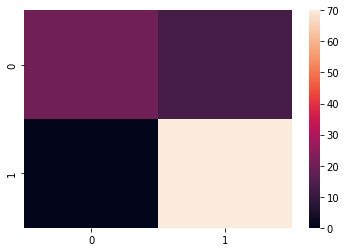

In [470]:
sns.heatmap(confusion_matrix(y_test,y_pred_cv_dt))

#  Random forest classifier

In [471]:
rf_model=RandomForestClassifier()
rf_model.fit(X_train,y_train)
y_pred_rf=rf_model.predict(X_test)

In [472]:
confusion_matrix(y_test,y_pred_rf)

array([[20, 13],
       [ 3, 67]])

In [473]:
roc_auc_score(y_test,y_pred_rf)

0.7816017316017316

<AxesSubplot:>

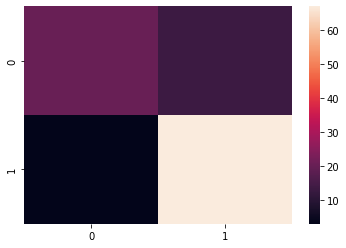

In [474]:
sns.heatmap(confusion_matrix(y_test,y_pred_rf))

In [475]:
rf_model.score(X_test,y_test)

0.8446601941747572

In [476]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.61      0.71        33
           1       0.84      0.96      0.89        70

    accuracy                           0.84       103
   macro avg       0.85      0.78      0.80       103
weighted avg       0.85      0.84      0.84       103



# SVC (support vector classifier)

In [477]:
model_svc=SVC(kernel='rbf')


In [478]:
params_cv=[{'C':[0.1,1,2,3,4,5],'gamma':[0.01,0.05,0.1,0.2,0.3,0.4,0.5,1]}]
cv_svc=GridSearchCV(estimator=model_svc,param_grid=params_cv)

In [479]:
cv_svc.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 2, 3, 4, 5],
                          'gamma': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]}])

In [480]:
y_predit_cv_svc=cv_svc.predict(X_test)

In [481]:
cv_svc.best_params_

{'C': 3, 'gamma': 0.2}

In [482]:
confusion_matrix(y_test,y_predit_cv_svc)

array([[20, 13],
       [ 0, 70]])

In [483]:
rf_model.predict([[1,1,1,0,0,1,0,2]])

array([0])

<AxesSubplot:>

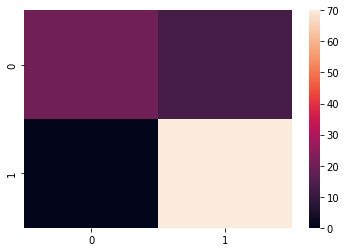

In [484]:
sns.heatmap(confusion_matrix(y_test,y_predit_cv_svc))

# Conclusion

### since , we do not want to give loan to the person who do not deserve it,
### Thus,we need to minimize the no. of False positives 
### Therefore , Random Forest classifier or decision tree classifier would be a good choice with minimizing the false positives

# Ensemble using bagging method (voting classifier) (Bonus)

In [485]:
from sklearn.ensemble import VotingClassifier
lr_model1=LogisticRegression()
dt_model1=DecisionTreeClassifier()
rf_model1=RandomForestClassifier()
model_svc1=SVC(kernel='rbf')

model = VotingClassifier(estimators=[('lr', lr_model1), ('dt', dt_model1),('rf',rf_model1),('sv',model_svc1)], voting='hard')
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.8446601941747572

In [486]:
y_predict_ensemble=model.predict(X_test)

In [487]:
confusion_matrix(y_test,y_predict_ensemble)

array([[20, 13],
       [ 3, 67]])

<AxesSubplot:>

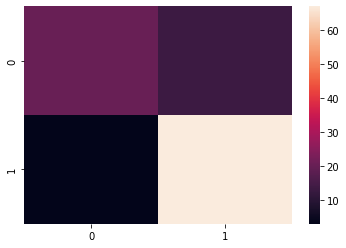

In [488]:
sns.heatmap(confusion_matrix(y_test,y_predict_ensemble))

In [489]:
roc_auc_score(y_test,y_predict_ensemble)

0.7816017316017316

### Not bad